# Comparing Random Forest vs Ensemble Algorithms

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns

RSEED = 108 # The sum of the LOST numbers

In [2]:
# Read the CSV
url = 'https://raw.githubusercontent.com/subashgandyer/datasets/main/great_customers.csv'
df = pd.read_csv(url)
df

,user_id,age,workclass,salary,education_rank,marital-status,occupation,race,sex,mins_beerdrinking_year,mins_exercising_year,works_hours,tea_per_year,coffee_per_year,great_customer_class
0,1004889,14.0,private,70773.00,9,Never-married,sales,not_caucasian,Male,0.0,0.0,40,399.0,NaN,0
1,1012811,25.0,private,76597.00,9,Divorced,sales,caucasian,Female,0.0,0.0,30,256.0,NaN,0
2,1006870,21.0,private,47947.25,10,Never-married,clerical,caucasian,Female,0.0,0.0,10,442.0,276.0,0
3,1022149,23.0,private,41740.25,7,Divorced,sales,caucasian,Female,0.0,0.0,20,NaN,NaN,0
4,1029558,26.0,private,NaN,9,Married,sales,not_caucasian,Male,NaN,0.0,36,NaN,120.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13594,1016807,42.0,private,55293.00,13,Married,executive,caucasian,Male,0.0,NaN,40,277.0,268.0,1
13595,1038859,58.0,self_employed,25928.25,14,Married,sales,caucasian,Male,0.0,0.0,40,337.0,NaN,1
13596,1041214,75.0,self_employed,16590.00,7,Married,executive,caucasian,Male,NaN,0.0,35,NaN,NaN,1
13597,1038013,45.0,private,25536.75,11,Divorced,executive,caucasian,Male,0.0,0.0,40,99.0,79.0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13599 entries, 0 to 13598
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 13599 non-null  int64  
 1   age                     13178 non-null  float64
 2   workclass               13056 non-null  object 
 3   salary                  13177 non-null  float64
 4   education_rank          13599 non-null  int64  
 5   marital-status          13599 non-null  object 
 6   occupation              13056 non-null  object 
 7   race                    13599 non-null  object 
 8   sex                     13599 non-null  object 
 9   mins_beerdrinking_year  13175 non-null  float64
 10  mins_exercising_year    13178 non-null  float64
 11  works_hours             13599 non-null  int64  
 12  tea_per_year            11170 non-null  float64
 13  coffee_per_year         11188 non-null  float64
 14  great_customer_class    13599 non-null

# Data Cleaning

In [4]:
# User ID is not relevant to final result
df = df.drop(['user_id'], axis=1)

In [5]:
# That 'marital-status' column name was giving me problems due to the dash. Let's rename it.
df = df.rename(columns={"marital-status": "marital_status"})

In [6]:
cat_df = df[['workclass', 'marital_status', 'occupation', 'race', 'sex']]

In [7]:
num_df = df[['age', 'salary', 'education_rank', 'mins_beerdrinking_year',
             'mins_exercising_year', 'works_hours', 'tea_per_year',
             'coffee_per_year']]

In [8]:
# Our target class... we'll need this later
y = df[['great_customer_class']]

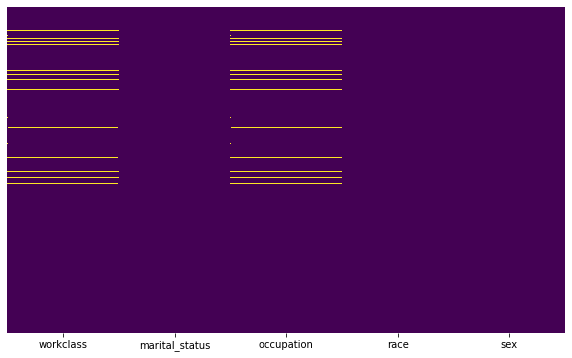

In [9]:
# Check for missing categorical data
plt.figure(figsize=(10,6))
sns.heatmap(cat_df.isna(), cbar=False, cmap='viridis', yticklabels=False)

## Fill missing categorical values with most common value

In [10]:
# workclass
cat_df.workclass.value_counts()

self_employed    5972
private          5957
government       1127
Name: workclass, dtype: int64

In [11]:
# since it's pretty evenly split, let's infer randomly
from numpy.random import choice
workclass_choice = choice(["self_employed", "private"], 1, p=[0.50, 0.50])[0]
cat_df['workclass'].fillna(workclass_choice, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [12]:
# occupation
cat_df.occupation.value_counts()

tech            5234
craft           1114
clerical         999
professional     984
service          973
executive        953
sales            920
factory          555
trucker          414
cleaner          399
farm             301
lawenf           161
estate_agent      47
soldier            2
Name: occupation, dtype: int64

In [13]:
# techies are the most common. Let's just use that...
cat_df['occupation'].fillna('tech', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


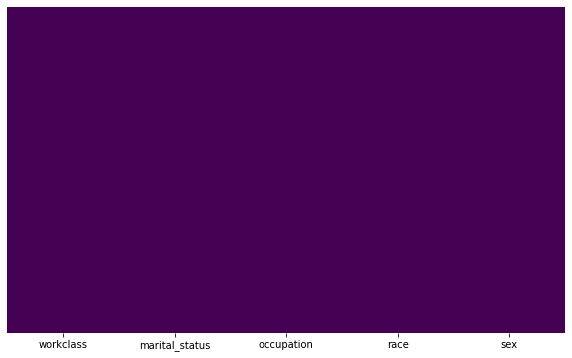

In [14]:
# How'd we do?
plt.figure(figsize=(10,6))
sns.heatmap(cat_df.isna(), cbar=False, cmap='viridis', yticklabels=False)

## Fill in missing numerical data

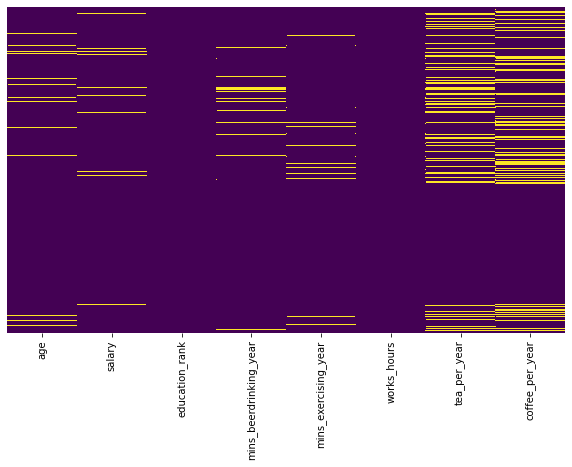

In [15]:
# Let's see what the damage is...
plt.figure(figsize=(10,6))
sns.heatmap(num_df.isna(), cbar=False, cmap='viridis', yticklabels=False)

In [16]:
# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

In [17]:
imputer.fit(num_df)
num_df_transformed = imputer.transform(num_df)

In [18]:
num_df = pd.DataFrame(data=num_df_transformed)
num_df.columns = ['age', 'salary', 'education_rank', 'mins_beerdrinking_year',
             'mins_exercising_year', 'works_hours', 'tea_per_year',
             'coffee_per_year']
num_df

,age,salary,education_rank,mins_beerdrinking_year,mins_exercising_year,works_hours,tea_per_year,coffee_per_year
0,14.0,70773.000000,9.0,0.000000,0.000000,40.0,399.000000,359.708169
1,25.0,76597.000000,9.0,0.000000,0.000000,30.0,256.000000,359.708169
2,21.0,47947.250000,10.0,0.000000,0.000000,10.0,442.000000,276.000000
3,23.0,41740.250000,7.0,0.000000,0.000000,20.0,217.276544,359.708169
4,26.0,37149.297355,9.0,447.920607,0.000000,36.0,217.276544,120.000000
...,...,...,...,...,...,...,...,...
13594,42.0,55293.000000,13.0,0.000000,46.034224,40.0,277.000000,268.000000
13595,58.0,25928.250000,14.0,0.000000,0.000000,40.0,337.000000,359.708169
13596,75.0,16590.000000,7.0,447.920607,0.000000,35.0,217.276544,359.708169
13597,45.0,25536.750000,11.0,0.000000,0.000000,40.0,99.000000,79.000000


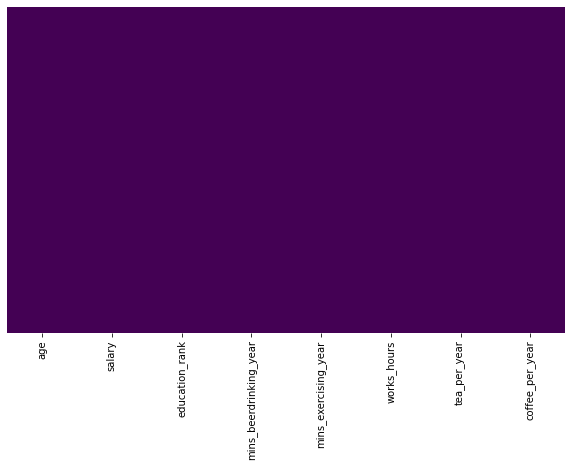

In [19]:
# Let's see how we did...
plt.figure(figsize=(10,6))
sns.heatmap(num_df.isna(), cbar=False, cmap='viridis', yticklabels=False)

# Data Preprocessing

In [20]:
# That categorical data needs to be converted.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [21]:
# are all the cat columns actual strings??
print(cat_df.workclass.value_counts())
print(cat_df.marital_status.value_counts())
print(cat_df.occupation.value_counts())
print(cat_df.race.value_counts())
print(cat_df.sex.value_counts())

private          6500
self_employed    5972
government       1127
Name: workclass, dtype: int64
Divorced         6625
Married          3559
Never-married    3141
Widowed           274
Name: marital_status, dtype: int64
tech            5777
craft           1114
clerical         999
professional     984
service          973
executive        953
sales            920
factory          555
trucker          414
cleaner          399
farm             301
lawenf           161
estate_agent      47
soldier            2
Name: occupation, dtype: int64
caucasian        12313
not_caucasian     1286
Name: race, dtype: int64
Male      10597
Female     3002
Name: sex, dtype: int64


In [22]:
# Yep. Let's label encode them all.
cat_df['workclass'] = le.fit_transform(cat_df['workclass'])
cat_df['marital_status'] = le.fit_transform(cat_df['marital_status'])
cat_df['occupation'] = le.fit_transform(cat_df['occupation']) 
cat_df['race'] = le.fit_transform(cat_df['race'])
cat_df['sex'] = le.fit_transform(cat_df['sex'])
cat_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,workclass,marital_status,occupation,race,sex
0,1,2,9,1,1
1,1,0,9,0,0
2,1,2,1,0,0
3,1,0,9,0,0
4,1,1,9,1,1
...,...,...,...,...,...
13594,1,1,4,0,1
13595,2,1,9,0,1
13596,2,1,4,0,1
13597,1,0,4,0,1


## Done! Let's bring our df back together

In [23]:
df_transform = pd.concat([cat_df, num_df], axis=1)
df_transform

,workclass,marital_status,occupation,race,sex,age,salary,education_rank,mins_beerdrinking_year,mins_exercising_year,works_hours,tea_per_year,coffee_per_year
0,1,2,9,1,1,14.0,70773.000000,9.0,0.000000,0.000000,40.0,399.000000,359.708169
1,1,0,9,0,0,25.0,76597.000000,9.0,0.000000,0.000000,30.0,256.000000,359.708169
2,1,2,1,0,0,21.0,47947.250000,10.0,0.000000,0.000000,10.0,442.000000,276.000000
3,1,0,9,0,0,23.0,41740.250000,7.0,0.000000,0.000000,20.0,217.276544,359.708169
4,1,1,9,1,1,26.0,37149.297355,9.0,447.920607,0.000000,36.0,217.276544,120.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13594,1,1,4,0,1,42.0,55293.000000,13.0,0.000000,46.034224,40.0,277.000000,268.000000
13595,2,1,9,0,1,58.0,25928.250000,14.0,0.000000,0.000000,40.0,337.000000,359.708169
13596,2,1,4,0,1,75.0,16590.000000,7.0,447.920607,0.000000,35.0,217.276544,359.708169
13597,1,0,4,0,1,45.0,25536.750000,11.0,0.000000,0.000000,40.0,99.000000,79.000000


In [24]:
# How does that look? 13599 Non-Null columns, and all values numeric?
df_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13599 entries, 0 to 13598
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   workclass               13599 non-null  int64  
 1   marital_status          13599 non-null  int64  
 2   occupation              13599 non-null  int64  
 3   race                    13599 non-null  int64  
 4   sex                     13599 non-null  int64  
 5   age                     13599 non-null  float64
 6   salary                  13599 non-null  float64
 7   education_rank          13599 non-null  float64
 8   mins_beerdrinking_year  13599 non-null  float64
 9   mins_exercising_year    13599 non-null  float64
 10  works_hours             13599 non-null  float64
 11  tea_per_year            13599 non-null  float64
 12  coffee_per_year         13599 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 1.3 MB


In [25]:
X = df_transform
X.shape

(13599, 13)

In [26]:
# We already grabbed y when we broke up the columns earlier
y = y['great_customer_class']
y.shape

(13599,)

# Feature Selection

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

num_feats = 10

In [28]:
cor_list = cor_support = cor_feature = []
for i in X.columns:
  cor = np.corrcoef(X[i], y)[0, 1]
  cor_list.append(cor)
cor_list = [0 if np.isnan(i) else i for i in cor_list] # replace NaN with 0
cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
cor_support = [True if i in cor_feature else False for i in list(X.columns)]

In [29]:
chi_support = chi_feature = []
chi_selector = SelectKBest(score_func=chi2, k=num_feats)
chi_selector.fit(X, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [30]:
rfe_support = rfe_feature = []
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X)
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=15)
rfe_selector.fit(X_train_minmax, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [31]:
embedded_lr_support = embedded_lr_feature = []
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
lr = LogisticRegression(penalty='l1', solver='liblinear')
embedded_lr_selector = SelectFromModel(lr, max_features=num_feats)
embedded_lr_selector = embedded_lr_selector.fit(X, y)
embedded_lr_support = embedded_lr_selector.get_support()
embedded_lr_feature = X.loc[:, embedded_lr_support].columns.tolist()

In [32]:
embedded_rf_support = embedded_rf_feature = []
sel = SelectFromModel(RandomForestClassifier(n_estimators = 40, bootstrap=False, max_features=num_feats))
sel.fit(X, y)
embedded_rf_feature = X.columns[(sel.get_support())]
embedded_rf_support = sel.get_support()

In [33]:
embedded_lgbm_support = embedded_lgbm_feature = []
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
  reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embedded_lgbm_selector = SelectFromModel(lgbc, max_features=num_feats)
embedded_lgbm_selector.fit(X, y)
embedded_lgbm_support = embedded_lgbm_selector.get_support()
embedded_lgbm_feature = X.loc[:,embedded_lgbm_support].columns.tolist()

In [34]:
feature_names = X.columns
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({
    'Feature':X.columns,
    'Pearson':cor_support,
    'Chi-2':chi_support,
    'RFE':rfe_support,
    'Logistics':embedded_lr_support,
    'Random Forest':embedded_rf_support,
    'LightGBM':embedded_lgbm_support
})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 10
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(13)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:85: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,coffee_per_year,True,True,True,True,True,True,6
2,works_hours,True,True,True,True,False,True,5
3,tea_per_year,True,True,False,True,True,True,5
4,salary,True,True,True,False,True,True,5
5,occupation,True,True,True,True,False,True,5
6,education_rank,True,True,True,True,True,False,5
7,age,False,True,True,True,True,True,5
8,workclass,True,True,True,True,False,False,4
9,mins_beerdrinking_year,True,True,True,False,True,False,4
10,mins_exercising_year,True,True,True,False,False,False,3


In [35]:
# It looks as though we have some clear winners!
# Let's take the top 9 features.
X_dropped = X.drop(columns=['mins_exercising_year','marital_status','sex','race'], axis=1)
X = X_dropped
X.head(5)

,workclass,occupation,age,salary,education_rank,mins_beerdrinking_year,works_hours,tea_per_year,coffee_per_year
0,1,9,14.0,70773.000000,9.0,0.000000,40.0,399.000000,359.708169
1,1,9,25.0,76597.000000,9.0,0.000000,30.0,256.000000,359.708169
2,1,1,21.0,47947.250000,10.0,0.000000,10.0,442.000000,276.000000
3,1,9,23.0,41740.250000,7.0,0.000000,20.0,217.276544,359.708169
4,1,9,26.0,37149.297355,9.0,447.920607,36.0,217.276544,120.000000


# Building our models

In [36]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=RSEED)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((9519, 9), (4080, 9), (9519,), (4080,))

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

In [38]:
rf = RandomForestClassifier(n_estimators=100, random_state=RSEED, max_features = 'sqrt')
svc = SVC(random_state=RSEED)
lr = LogisticRegression(random_state=RSEED)
nb = GaussianNB()
knn = KNeighborsClassifier()
results = []

In [39]:
# random forest
rf.fit(xtrain, ytrain)
preds = rf.predict(xtest)
score = accuracy_score(ytest, preds)
results.append("rf accuracy: %0.3f" % score)

In [40]:
# svc
svc.fit(xtrain, ytrain)
preds = svc.predict(xtest)
score = accuracy_score(ytest, preds)
results.append("svc accuracy: %0.3f" % score)

In [41]:
# logistic regression
lr.fit(xtrain, ytrain)
preds = lr.predict(xtest)
score = accuracy_score(ytest, preds)
results.append("lr accuracy: %0.3f" % score)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [42]:
# naive bayes
nb.fit(xtrain, ytrain)
preds = nb.predict(xtest)
score = accuracy_score(ytest, preds)
results.append("nb accuracy: %0.3f" % score)

In [43]:
# k nearest neighbours
knn.fit(xtrain, ytrain)
preds = knn.predict(xtest)
score = accuracy_score(ytest, preds)
results.append("knn accuracy: %0.3f" % score)

# Ensemble Result

In [44]:
from sklearn.ensemble import VotingClassifier

In [45]:
rf = RandomForestClassifier(n_estimators=100, random_state=RSEED, max_features = 'sqrt')
lr = LogisticRegression(random_state=RSEED)
knn = KNeighborsClassifier()

model = VotingClassifier(estimators=[('rf', rf), ('lr', lr), ('knn', knn)], voting='hard')

In [46]:
model.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_features='sqrt',
                                                     random_state=108)),
                             ('lr', LogisticRegression(random_state=108)),
                             ('knn', KNeighborsClassifier())])

In [47]:
# What's the ensemble's score??
score = model.score(xtest, ytest)
results.append("Ensemble accuracy: %0.3f" % score)

# Results:

In [48]:
print(results)

['rf accuracy: 0.940', 'svc accuracy: 0.930', 'lr accuracy: 0.932', 'nb accuracy: 0.920', 'knn accuracy: 0.926', 'Ensemble accuracy: 0.935']


# As we can see, Random Forest slightly outperformed the ensemble in terms of raw accuracy. To choose a model going forward, however, I would still choose the ensemble algorithm, so that the model may be more flexible with data that it hasn't seen before.